In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
color_pal = sns.color_palette()

In [18]:
df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

columns_to_eliminate = ['InvoiceSectionName',
                        'MeterCategory',
                        'MeterSubCategory',
                        'MeterName',
                        'SubscriptionName',
                        'ResourceGroup',
                        'ConsumedService',
                        'ResourceLocation',
                        'ResourceName',
                        ]
#Mapping gategorical feature in order to be able to feed it to the model

df.drop(columns=columns_to_eliminate, inplace=True)
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
df = df.drop_duplicates(subset=['CostInBillingCurrency'])
df.shape

(89, 1)

# XGB Standard

In [19]:
def da(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the sign of the difference between consecutive actual values
    actual_diff = np.sign(y_true[1:] - y_true[:-1])
    
    # Calculate the sign of the difference between the predicted value and the actual value of the previous day
    pred_diff = np.sign(y_pred[1:] - y_true[:-1])
    
    # Calculate the number of times the signs are the same
    num_correct = np.sum(actual_diff == pred_diff)
    
    # Calculate the total number of comparisons (which is one less than the length of the time series)
    total_comparisons = len(y_true) - 1
    
    # Calculate the directional accuracy
    da = num_correct / total_comparisons
    
    return da

In [20]:
def create_features(df):

    df = df.copy()

    df['DayOfWeek'] = df.index.day_of_week
    df['Month'] = df.index.month
    #df['DayOfYear'] = df.index.dayofyear

    return df

In [21]:
df['TotalCost_PreviousDay'] = df['CostInBillingCurrency'].shift(1)
df['TotalCost_PreviousDay-1'] = df['CostInBillingCurrency'].shift(2)
df['TotalCost_PreviousDay-2'] = df['CostInBillingCurrency'].shift(3)
df['Avg_TotalCost_Prev3Days'] = df['TotalCost_PreviousDay'].rolling(window=3).mean()
df['Avg_TotalCost_Prev5Days'] = df['TotalCost_PreviousDay'].rolling(window=5).mean()
df['Avg_TotalCost_Prev7Days'] = df['TotalCost_PreviousDay'].rolling(window=7).mean()

df = create_features(df)
df.dropna(axis=0, inplace=True)
df = df.sort_index()
df = df[3:]
df.shape

(79, 9)

In [22]:
x = ['TotalCost_PreviousDay', 'TotalCost_PreviousDay-1',
       'TotalCost_PreviousDay-2', 'Avg_TotalCost_Prev3Days',
       'Avg_TotalCost_Prev5Days', 'Avg_TotalCost_Prev7Days',
     'DayOfWeek',
      'Month',
     ]
y = 'CostInBillingCurrency'

In [23]:
train = df[:50]
val = df[50:59]
test = df[59:]
print(train.shape, val.shape, test.shape)

x_train, y_train = train[x], train[y]
x_val, y_val = val[x], val[y]
x_test, y_test = test[x], test[y]

(50, 9) (9, 9) (20, 9)


In [26]:
reg = xgb.XGBRegressor( base_score=0.5,
                        booster='gbtree',
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = 'rmse'
                      )

In [27]:
reg.fit(x_train, y_train,
            eval_set=[(x_val, y_val)],
            verbose=100)

[0]	validation_0-rmse:109.66483
[100]	validation_0-rmse:45.32393
[200]	validation_0-rmse:25.94562
[300]	validation_0-rmse:23.43412
[330]	validation_0-rmse:23.61320


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

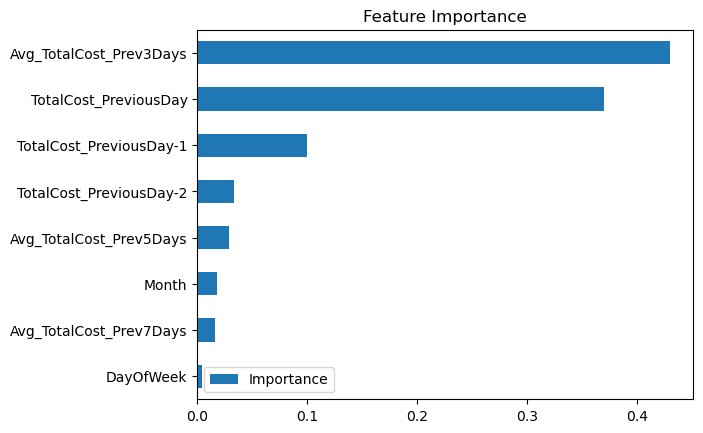

In [28]:
FI = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['Importance'])
FI.sort_values('Importance').plot(kind = 'barh', title='Feature Importance')
plt.show()

/var/folders/d6/kddxwvns2sq07r3lbcsg3wz40000gn/T/ipykernel_63666/3892962733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(test[x])


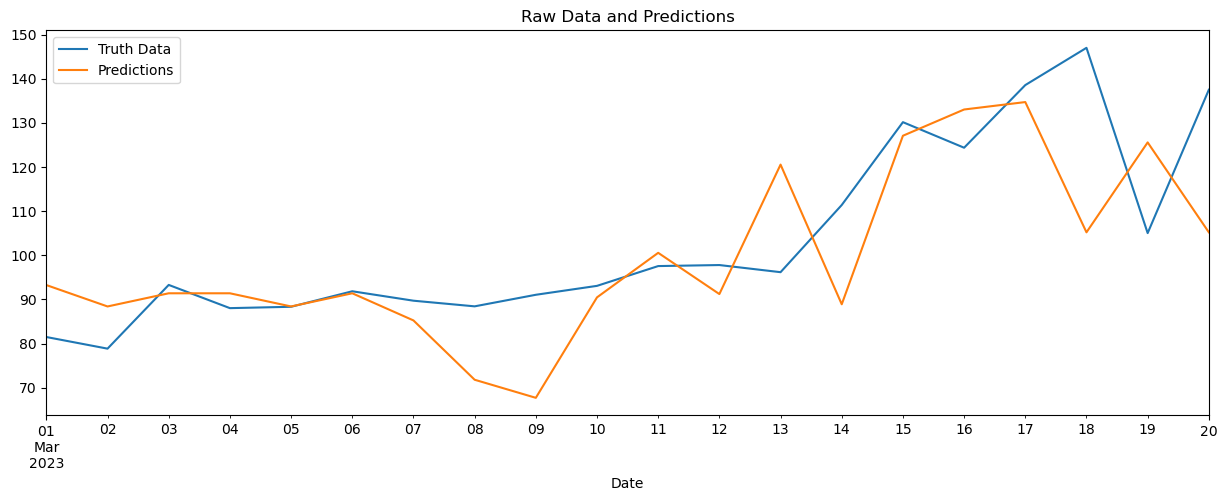

In [29]:
test['prediction'] = reg.predict(test[x])
pred = test['prediction']

fig, ax = plt.subplots(figsize = (15,5))
ax = test['CostInBillingCurrency'].plot(ax = ax, color = color_pal[0])
test['prediction'].plot(ax = ax, color = color_pal[1])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [30]:
def insert_firtst_day(p, DF):
    p = np.array(p)
    p = np.insert(p, 0, DF['CostInBillingCurrency'][0])  

    return p

pred = insert_firtst_day(pred, test)

In [31]:
mse = mean_squared_error(test['CostInBillingCurrency'], test['prediction'])
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 16.674252426798766


In [32]:
print("MDA =", da(pred,df['CostInBillingCurrency'][:21]))

MDA = 0.6


# XGB Tuned

(50, 9) (9, 9) (20, 9)
100%|██████████| 100/100 [01:06<00:00,  1.51trial/s, best loss: 188.93119293139142]


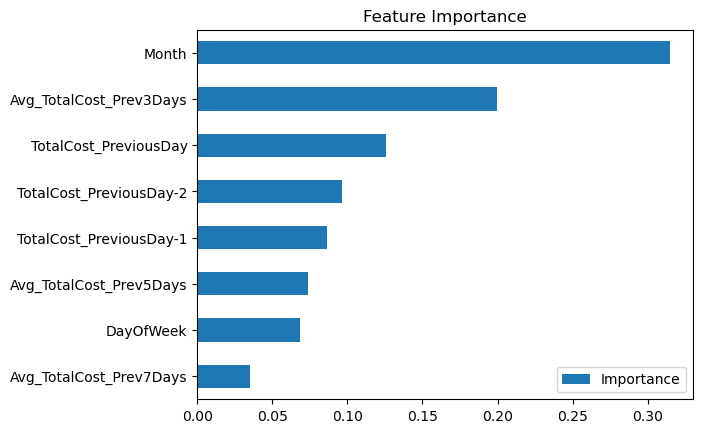

/var/folders/d6/kddxwvns2sq07r3lbcsg3wz40000gn/T/ipykernel_63666/1133042461.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = best_model.predict(test[x])


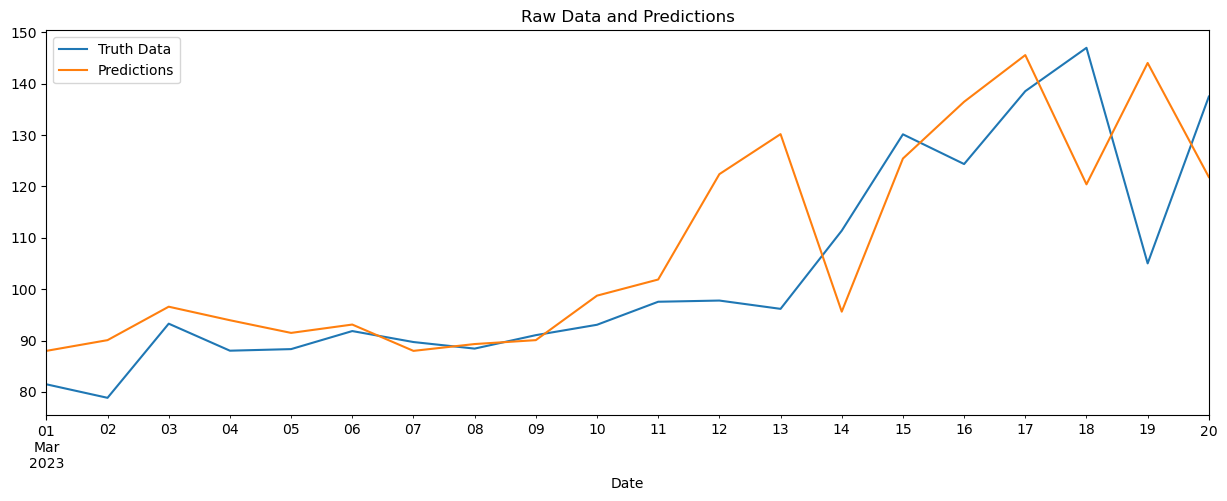

RMSE: 15.796617524615867


In [34]:
# HYPERPARAM TUNING XGB

df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")


columns_to_eliminate = ['InvoiceSectionName',
                        'MeterCategory',
                        'MeterSubCategory',
                        'MeterName',
                        'SubscriptionName',
                        'ResourceGroup',
                        'ConsumedService',
                        'ResourceLocation',
                        'ResourceName',
                        ]
#Mapping gategorical feature in order to be able to feed it to the model

df.drop(columns=columns_to_eliminate, inplace=True)
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
df = df.drop_duplicates(subset=['CostInBillingCurrency'])
df.shape

def create_features(df):

    df = df.copy()

    df['DayOfWeek'] = df.index.day_of_week
    df['Month'] = df.index.month
    #df['DayOfYear'] = df.index.dayofyear

    return df

df['TotalCost_PreviousDay'] = df['CostInBillingCurrency'].shift(1)
df['TotalCost_PreviousDay-1'] = df['CostInBillingCurrency'].shift(2)
df['TotalCost_PreviousDay-2'] = df['CostInBillingCurrency'].shift(3)
df['Avg_TotalCost_Prev3Days'] = df['TotalCost_PreviousDay'].rolling(window=3).mean()
df['Avg_TotalCost_Prev5Days'] = df['TotalCost_PreviousDay'].rolling(window=5).mean()
df['Avg_TotalCost_Prev7Days'] = df['TotalCost_PreviousDay'].rolling(window=7).mean()

df = create_features(df)
df.dropna(axis=0, inplace=True)
df = df.sort_index()
df = df[3:]
df.shape

x = ['TotalCost_PreviousDay', 'TotalCost_PreviousDay-1',
       'TotalCost_PreviousDay-2', 'Avg_TotalCost_Prev3Days',
       'Avg_TotalCost_Prev5Days', 'Avg_TotalCost_Prev7Days',
     'DayOfWeek',
      'Month',
     ]
y = 'CostInBillingCurrency'

train = df[:50]
val = df[50:59]
test = df[59:]
print(train.shape, val.shape, test.shape)

x_train, y_train = train[x], train[y]
x_val, y_val = val[x], val[y]
x_test, y_test = test[x], test[y]

def objective(params):
    model = xgb.XGBRegressor(**params)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose = False)
    preds = model.predict(x_test)
    mse = mean_squared_error(y_test, preds)
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'eval_metric':'rmse'
}

# Perform the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

best_params = {'colsample_bytree': 0.23753976206916486,
 'gamma': 0.6804251691581721,
 'learning_rate': 0.337725481307377,
 'max_depth': 8,
 'min_child_weight': 8,
 'n_estimators': 121,
 'subsample': 0.3595108186333437}

#best_params = {key: value for key, value in best.items()}
best_model = xgb.XGBRegressor(**best_params, eval_metric = 'rmse')

best_model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose = False)

FI = pd.DataFrame(data = best_model.feature_importances_, index=best_model.feature_names_in_, columns=['Importance'])
FI.sort_values('Importance').plot(kind = 'barh', title='Feature Importance')
plt.show()

test['prediction'] = best_model.predict(test[x])

fig, ax = plt.subplots(figsize = (15,5))
ax = test['CostInBillingCurrency'].plot(ax = ax, color = color_pal[0])
test['prediction'].plot(ax = ax, color = color_pal[1])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

mse = mean_squared_error(test['CostInBillingCurrency'], test['prediction'])
rmse = np.sqrt(mse)

print("RMSE:", rmse)

predizioni_tuning = test

In [81]:

pred = best_model.predict(test[x])
costi = df['CostInBillingCurrency'][:21]

def insert_firtst_day(p, DF):
    p = np.array(p)
    p = np.insert(p, 0, DF['CostInBillingCurrency'][0])  

    return p

pred = insert_firtst_day(pred, test)

print("MDA =", da(pred,costi))

MDA = 0.35
